In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import timedelta

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('Panel_Data.csv')

In [4]:
global_df = pd.read_csv('GlobalTemperatures.csv')

In [5]:
global_df['Year'] = pd.to_datetime(global_df['dt']).dt.year

In [6]:
# dataframe for yearly average temperature and uncertainty
group_global = global_df.groupby(['Year']).agg({ 
    'LandAverageTemperature': 'mean',
    'LandAverageTemperatureUncertainty': 'mean'
}).reset_index()

In [7]:
group_global.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 3 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Year                               266 non-null    int64  
 1   LandAverageTemperature             266 non-null    float64
 2   LandAverageTemperatureUncertainty  266 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 6.4 KB


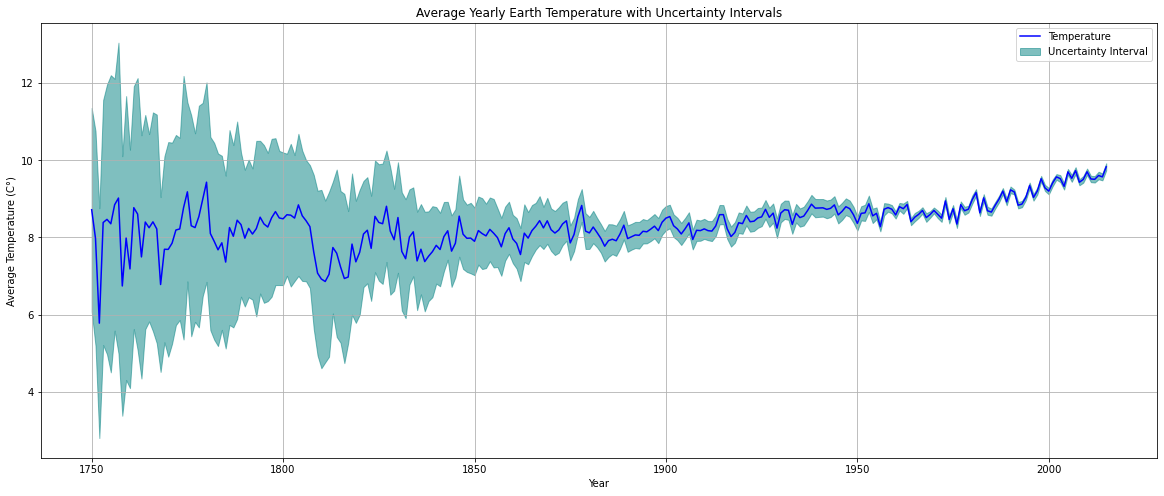

In [8]:
# plot global temperature over time with uncertainty range
plt.figure(figsize=(20, 8))

plt.plot(group_global['Year'], group_global['LandAverageTemperature'], label='Temperature', color='blue')

plt.fill_between(group_global['Year'], group_global['LandAverageTemperature'] - group_global['LandAverageTemperatureUncertainty'],
                 group_global['LandAverageTemperature'] + group_global['LandAverageTemperatureUncertainty'],
                 color='teal', alpha=0.5, label='Uncertainty Interval')

plt.title('Average Yearly Earth Temperature with Uncertainty Intervals')
plt.xlabel('Year')
plt.ylabel('Average Temperature (C°)')
plt.legend()
plt.grid(True)

plt.show()

In [9]:
group_global['date'] = pd.to_datetime(group_global['Year'].astype(str) + '-01-01')

# Drop the original 'year' column if needed
group_global.drop('Year', axis=1, inplace=True)

In [10]:
group_global.head()

,LandAverageTemperature,LandAverageTemperatureUncertainty,date
0,8.719364,2.637818,1750-01-01
1,7.976143,2.781143,1751-01-01
2,5.779833,2.977000,1752-01-01
3,8.388083,3.176000,1753-01-01
4,8.469333,3.494250,1754-01-01


In [11]:
global_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3180 entries, 0 to 3179
Data columns (total 10 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   dt                                         3180 non-null   object 
 1   LandAverageTemperature                     3180 non-null   float64
 2   LandAverageTemperatureUncertainty          3180 non-null   float64
 3   LandMaxTemperature                         1992 non-null   float64
 4   LandMaxTemperatureUncertainty              1992 non-null   float64
 5   LandMinTemperature                         1992 non-null   float64
 6   LandMinTemperatureUncertainty              1992 non-null   float64
 7   LandAndOceanAverageTemperature             1992 non-null   float64
 8   LandAndOceanAverageTemperatureUncertainty  1992 non-null   float64
 9   Year                                       3180 non-null   int64  
dtypes: float64(8), int64(1),

In [12]:
gdf2 = global_df[['dt', 'LandAverageTemperature', 'LandAverageTemperatureUncertainty', 'Year']]
gdf2.head()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,Year
0,1750-01-01,3.034,3.574,1750
1,1750-02-01,3.083,3.702,1750
2,1750-03-01,5.626,3.076,1750
3,1750-04-01,8.490,2.451,1750
4,1750-05-01,11.573,2.072,1750


In [13]:
# convert dt to datetime object
gdf2['dt'] = pd.to_datetime(gdf2['dt'], format='%Y-%m')

In [14]:
# make date the index of the dataframe
gdf2.index = gdf2['dt']
del gdf2['dt']

In [16]:
print(gdf2.head())

            LandAverageTemperature  LandAverageTemperatureUncertainty  Year
dt                                                                         
1750-01-01                   3.034                              3.574  1750
1750-02-01                   3.083                              3.702  1750
1750-03-01                   5.626                              3.076  1750
1750-04-01                   8.490                              2.451  1750
1750-05-01                  11.573                              2.072  1750


In [18]:
# grouped global data frame
ggdf = group_global

In [19]:
# make index of ggdf date
ggdf.index = ggdf['date']
del ggdf['date']
print(ggdf.head())

            LandAverageTemperature  LandAverageTemperatureUncertainty
date                                                                 
1750-01-01                8.719364                           2.637818
1751-01-01                7.976143                           2.781143
1752-01-01                5.779833                           2.977000
1753-01-01                8.388083                           3.176000
1754-01-01                8.469333                           3.494250


In [20]:
del ggdf['LandAverageTemperatureUncertainty']

In [21]:
rolling_mean = ggdf.rolling(10).mean()
rolling_std = ggdf.rolling(10).std()

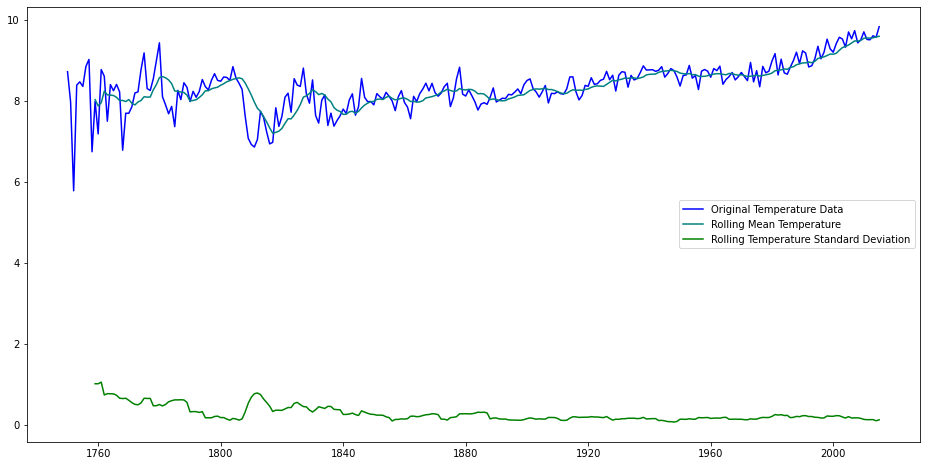

In [23]:
# plot rolling mean and std with temperature data
plt.figure(figsize=(16, 8))
plt.plot(ggdf, color='blue', label = 'Original Temperature Data')
plt.plot(rolling_mean, color='teal', label = 'Rolling Mean Temperature')
plt.plot(rolling_std, color='green', label = 'Rolling Temperature Standard Deviation')
plt.legend(loc=7)
plt.show()

In [24]:
# Dickey Fuller Stationarity Test
adft = adfuller(ggdf, autolag='AIC')

In [25]:
# Format Dickey Fuller Output
output_df = pd.DataFrame({"Metric":["Test Statistics","*p-value","No. of lags used","Number of observations used", "critical value (1%)", "critical value (5%)", "critical value (10%)"]  , 
"Value": [adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]})
print(output_df)
print('*Not Stationary!')

                        Metric       Value
0              Test Statistics   -0.191872
1                     *p-value    0.939484
2             No. of lags used   15.000000
3  Number of observations used  250.000000
4          critical value (1%)   -3.456781
5          critical value (5%)   -2.873172
6         critical value (10%)   -2.572969
*Not Stationary!


In [26]:
# 1 year lag autocorrelation
autocorr1 = ggdf['LandAverageTemperature'].autocorr(lag=1)
autocorr1

0.7250748621910698

In [27]:
# 3 year lag autocorelation
autocorr3 = ggdf['LandAverageTemperature'].autocorr(lag=3)
autocorr3

0.6414517893885482

In [28]:
# 5 year lag autocorrelation
autocorr5 = ggdf['LandAverageTemperature'].autocorr(lag=5)
autocorr5

0.587007064162747

In [37]:
# create 13 year subset of monthly data
gdf13 = gdf2.tail(156)

In [38]:
ggdf13

,LandAverageTemperature,LandAverageTemperatureUncertainty,Year
dt,,,
2003-01-01,3.981,0.070,2003
2003-02-01,4.085,0.097,2003
2003-03-01,6.048,0.055,2003
2003-04-01,9.154,0.074,2003
2003-05-01,12.153,0.095,2003
...,...,...,...
2015-08-01,14.755,0.072,2015
2015-09-01,12.999,0.079,2015
2015-10-01,10.801,0.102,2015


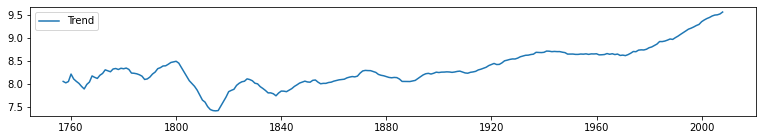

In [54]:
# use seasonal decomposition on entire dataset to further visualize trend 
result = seasonal_decompose(ggdf['LandAverageTemperature'], model='additive', period=15)
trend = result.trend
plt.figure(figsize=(13, 2))
plt.plot(trend, label='Trend')
plt.legend()
plt.show()

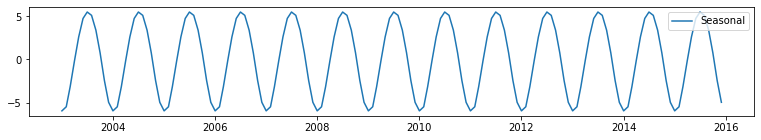

In [55]:
# use seasonal decompostion on 13 year subset of monthly data to visualize seasonal pattern
result = seasonal_decompose(gdf13['LandAverageTemperature'], model='additive', period=12)
seasonal = seasonal_decompostion.seasonal
plt.figure(figsize=(13, 2))
plt.plot(seasonal, label='Seasonal')
plt.legend()
plt.show()